In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

In [3]:
videos_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/ChimpRec-Dataset/CCR/data/videos"
bodies_annotations_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/ChimpRec-Dataset/CCR/annotations/body_data.csv"
faces_annotations_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/ChimpRec-Dataset/CCR/annotations/face_data.csv"
frames_annotations_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/ChimpRec-Dataset/CCR/annotations/frame_data.csv"

In [4]:
bodies_annotations = pd.read_csv(bodies_annotations_path)
faces_annotations = pd.read_csv(faces_annotations_path)
frames_annotations = pd.read_csv(frames_annotations_path)

Fonctions utiles:

In [5]:
def get_frame(video_path, frame_number): 
    if not os.path.exists(video_path):
        print(f"Erreur : Impossible de trouver {video_path}")
    else:
        # Charger la vidéo avec OpenCV
        cap = cv2.VideoCapture(video_path)
        
        # Aller à la frame demandée
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Lire la frame
        ret, frame = cap.read()
        cap.release()

        if not ret:
            print(f"Erreur : Impossible de lire la frame {frame_number} de {video_path}")
        else:
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
def yolo_to_pixel(coord, img_W, img_H):
    x, y, w, h = coord
    
    x1 = max(0, int((x - w / 2) * img_W)) 
    y1 = max(0, int((y - h / 2) * img_H))
    x2 = min(img_W, int((x + w / 2) * img_W))
    y2 = min(img_H, int((y + h / 2) * img_H))

    return x1, y1, x2, y2


def face_pixel_coord(coord, img_width, img_height):
    x, y, w, h = coord
    x1 = int(x * img_width)
    y1 = int(y * img_height)
    x2 = int((x + w) * img_width)
    y2 = int((y + h) * img_height)
    return x1, y1, x2, y2

def body_pixel_coord(coord, img_width, img_height):
    x, y, w, h = coord
    x1 = int(x*img_width)
    y1 = int(y*img_width)
    x2 = int(x*img_width+w*img_width)
    y2 = int((y*img_width)+h*img_height)
    return x1, y1, x2, y2

Test sur nos images:

1080 1920


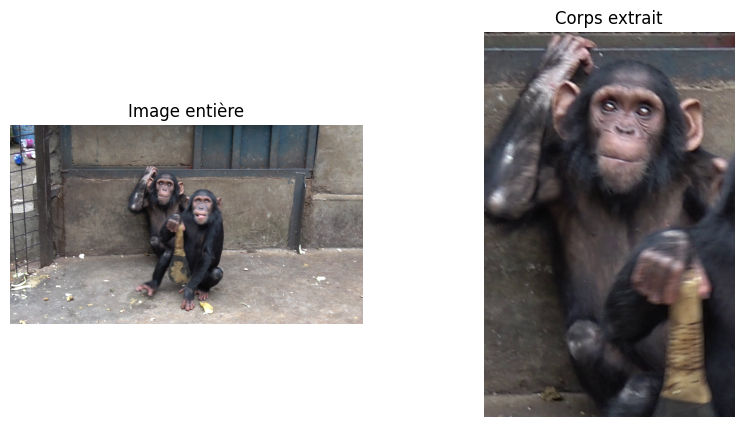

In [6]:
from PIL import Image
test_image_path = "C:/Users/julie/Documents/Unif/Mémoire/YOLO_detection/images/train/20241009 - 09h07_frame_0217.png"

coord = 0.427685, 0.441051, 0.173193, 0.473898

# Charger l'image avec OpenCV
img = Image.open(test_image_path)
frame = np.array(img)

# Vérifier que l'image a bien été chargée
if frame is None:
    print(f"Erreur : Impossible de charger l'image {test_image_path}")
else:
    # Dimensions de l'image
    height, width, _ = frame.shape
    print(height, width)

    # Conversion YOLO -> Pixels
    x1, y1, x2, y2 = yolo_to_pixel(coord, width, height)

    # Vérifier que la zone est valide
    if x1 >= x2 or y1 >= y2:
        print(f"Erreur : Coordonnées invalides ({x1}, {y1}) -> ({x2}, {y2})")
    else:
        cropped_body = frame[y1:y2, x1:x2]

        # Afficher l'image en entier et recadrée
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(frame)
        plt.title("Image entière")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cropped_body)
        plt.title("Corps extrait")
        plt.axis("off")

        plt.show()

Test sur CCR:

        year                     video  frame  track         x         y  \
560355  2012  20120210142221_PAB20.mp4  30898    640  0.298438  0.325521   

               w         h label  
560355  0.216146  0.332407  JIRE  
1080
1920
Coordonnées en pixels : (573, 625) -> (988, 983)


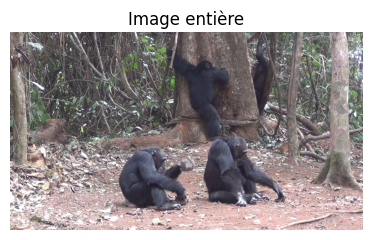

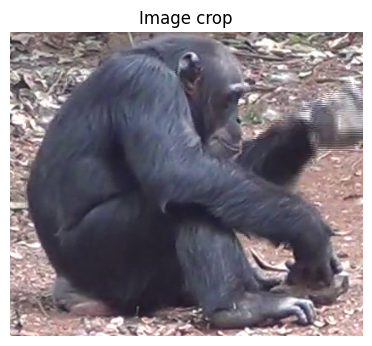

In [7]:
keeped_body_annotations = bodies_annotations.sample(n=1, random_state=936)
print(keeped_body_annotations)

year = keeped_body_annotations["year"].values[0]
video = keeped_body_annotations["video"].values[0]
frame_number = keeped_body_annotations["frame"].values[0]
coord = keeped_body_annotations["x"].values[0], keeped_body_annotations["y"].values[0], keeped_body_annotations["w"].values[0], keeped_body_annotations["h"].values[0]

# Construire le chemin de la vidéo
video_path = f"{videos_path}/{year}/{video}"

frame_rgb = get_frame(video_path, frame_number)
#cv2.imwrite("C:/Users/julie/Downloads/frame_rgb.jpg", cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))
height, width, _ = frame_rgb.shape
print(height)
print(width)

x1,y1,x2,y2 = body_pixel_coord(coord, width, height)
print(f"Coordonnées en pixels : ({x1}, {y1}) -> ({x2}, {y2})")

# Vérifier que la zone est valide
if x1 >= x2 or y1 >= y2:
    print(f"Erreur : Coordonnées invalides ({x1}, {y1}) -> ({x2}, {y2})")
else:
    cropped_body = frame_rgb[y1:y2, x1:x2]

    # Afficher l'image en entier et recadrée

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(frame_rgb)
    plt.title("Image entière")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_body)
    plt.title("Image crop")
    plt.axis("off")
    plt.show()

Structure finale du code pour créer le dataset de training:

In [15]:
def get_cropped_body(body): 
    year = body["year"].values[0]
    video = body["video"].values[0]
    frame_number = body["frame"].values[0]
    coord = body["x"].values[0], body["y"].values[0], body["w"].values[0], body["h"].values[0]

    # Récupérer la frame qui nous intéresse
    video_path = f"{videos_path}/{year}/{video}"
    frame_rgb = get_frame(video_path, frame_number)

    # Calculer la bounding box en termes de pixels
    height, width, _ = frame_rgb.shape
    x1, y1, x2, y2 = body_pixel_coord(coord, width, height)

    # Ajuster les coordonnées pour éviter tout dépassement
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(width, x2), min(height, y2)

    return frame_rgb[y1:y2, x1:x2], (x1, y1, x2, y2)



def get_cropped_face(face): 
    year = face["year"]
    video = face["video"]
    frame_number = face["frame"]
    coord = face["x"], face["y"], face["w"], face["h"]

    #récupérer la frame qui nous intéresse
    video_path = f"{videos_path}/{year}/{video}"
    frame_rgb = get_frame(video_path, frame_number)

    #calculer la bounding box en terme de pixel
    height, width, _ = frame_rgb.shape
    x1,y1,x2,y2 = face_pixel_coord(coord,width,height)

    return frame_rgb[y1:y2, x1:x2], (x1,y1,x2,y2)


def face_to_yolo_relative_to_body(body_bbox, face_bbox):
    bx1, by1, bx2, by2 = body_bbox 
    fx1, fy1, fx2, fy2 = face_bbox  
    
    if fx1 < bx1: 
        fx1 = bx1
    if fy1 < by1: 
        fy1 = by1
    if fx2 > bx2: 
        fx2 = bx2
    if fy2 > by2: 
        fy2 = by2

    # Taille du bounding box du corps
    body_width = bx2 - bx1
    body_height = by2 - by1

    # Coords du visage dans le référentiel du corps
    rel_x1 = fx1 - bx1
    rel_y1 = fy1 - by1
    rel_x2 = fx2 - bx1
    rel_y2 = fy2 - by1

    # Calcul YOLO par rapport au corps
    x_center = (rel_x1 + rel_x2) / 2 / body_width
    y_center = (rel_y1 + rel_y2) / 2 / body_height
    width = (rel_x2 - rel_x1) / body_width
    height = (rel_y2 - rel_y1) / body_height

    return x_center, y_center, width, height

In [16]:
#Pour ne garder que les noms et pas le label NEGATIVE
filtered_labels = faces_annotations[faces_annotations["label"] != "NEGATIVE"]["label"].unique()

for name in filtered_labels:
    counter = 0
    valid_faces = faces_annotations[faces_annotations["label"] == name].merge(
        bodies_annotations[['year', 'video', 'frame', 'label']],
        on=['year', 'video', 'frame', 'label'],
        how='inner'
    )

    keeped_face_annotations = valid_faces.sample(n=154, random_state=42)    
    for _, face in keeped_face_annotations.iterrows():
        #Trouver le corps correspondant à la face sélectionnée
        matching_body = bodies_annotations[
            (bodies_annotations["year"] == face["year"]) &
            (bodies_annotations["video"] == face["video"]) &
            (bodies_annotations["frame"] == face["frame"]) & 
            (bodies_annotations["label"] == face["label"])
        ]
        if matching_body.empty:
            print(counter) 
            continue
        
        #crop l'image autour du body et stocker ce crop au bon endroit (dans images/train)
        cropped_body, body_coord = get_cropped_body(matching_body)
        image_pil = Image.fromarray(np.uint8(cropped_body))
        image_pil.save(f"C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset/images/train/{name}{counter}.png")

        #calculer les coordonnées relatives du visage par rapport au crop
        cropped_face, face_coord = get_cropped_face(face)
        body_height, body_width, _ = cropped_body.shape
        face_relative_to_body = face_to_yolo_relative_to_body(body_coord, face_coord)
    
        #stocker ces nouvelles coordonnées sous le format YOLO au bon endroit (dans labels/train)
        with open(f"C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset/labels/train/{name}{counter}.txt", "w") as file:
            file.write("0 " + " ".join(map(str, face_relative_to_body))) 
        counter+=1

Pour vérifier:

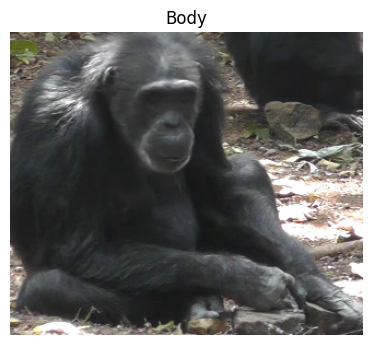

(0.0, 0.40092879256965946, 0.2841726618705036, 0.3188854489164087, 0.3597122302158273)


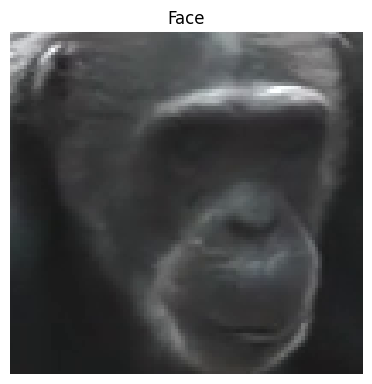

In [ ]:
img = Image.open("C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset/images/train/face5.png")
frame = np.array(img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("Body")
plt.axis("off")
plt.show()

with open("C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset/labels/train/face5.txt", "r") as file:
    content = file.readline().strip()
    values = content.split(" ")

values = tuple([float(v) for v in values])

print(values)

height, width, _ = frame.shape

x1,y1,x2,y2 = yolo_to_pixel(values[1:], width, height)
test_image = frame[y1:y2, x1:x2]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Face")
plt.axis("off")
plt.show()


In [13]:
filtered_labels = faces_annotations[faces_annotations["label"] != "NEGATIVE"]["label"].unique()
print(len(filtered_labels))

13
